# Machine Learning

Machine Learning (ML) in Artificial Intelligence is the field of study that focuses on developing algorithms and models that enable computers to learn patterns from data and make predictions or decisions without explicit programming. Its goal is to build models that can generalize from observed data to make accurate predictions or decisions on new, unseen data. ML systems can be divided into two broad categories: predictive ML and generative AI.

* **Problem Framing**: First, you need to consider if ML is the right approach to the problem and how to frame the problem in ML terms. 
* **Model Evaluation**: *A non-ML solution is the benchmark to measure an ML solution against* refers to using non-Machine Learning solutions as the baseline for evaluating and comparing the performance of solutions. This evaluation involve various metrics such as Accuracy, F1 Score, etc.

[Read Google's guidelines here.](https://developers.google.com/machine-learning/problem-framing/problem)

### Import Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Detecting Ride Anomalies Using DBSCAN

In this implementation, we apply unsupervised learning to detect anomalies in ride data. Specifically, we use the [Density-Based Spatial Clustering of Applications with Noise](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) algorithm to identify clusters in the data and the elements that don't belong to any cluster. These unclustered elements, also referred to as noise or outliers, might signify instances where unusual or unexpected events have occurred. The example provided illustrates this concept in detail. This example is taken from Packt.

<Axes: xlabel='ride_dist', ylabel='ride_time'>

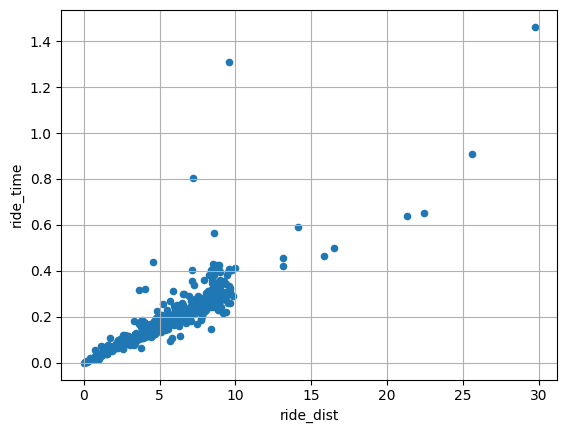

In [4]:
df = pd.read_csv('data/rides.csv')
df.plot(x='ride_dist', y='ride_time', kind='scatter', grid=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

def cluster_and_label(X, create_and_show_plot=True):
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    metadata = {
        'clusters': n_clusters_,
        'noise': n_noise_,
        'silhouette_coefficient': metrics.silhouette_score(X, labels),
        'labels': labels,
    }

    if create_and_show_plot == True:
        fig = plt.figure(figsize=(6,6))
        unique_labels = set(labels)
        colors = [plt.cm.cool(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels== k)
            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)
            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], '^', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)
        
        plt.xlabel('Standard Scaled Ride Dist.')
        plt.ylabel('Standard Scaled Ride Time')
        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.grid()
        plt.show()
    else:
        pass
    return metadata

X = df[['ride_dist', 'ride_time']]
results = cluster_and_label(X)
df['label'] = results['labels']

## Obstacle Detection using CNN

In [ ]:
from sklearn.metrics import f1_score
from skimage.transform import resize

model_name = "obstacle_detection_v3"

X = np.load("data/od_X.npy", allow_pickle=True)
y = np.load("data/od_y.npy", allow_pickle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32,
          callbacks=[checkpoint_callback, tensorboard_callback, csv_logger],
          validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)
model.save(f"{model_name}.h5")
model.summary()

In [ ]:
model = load_model('obstacle_detection_v3.h5')
predictions = model.predict(data)

## Dance Classification Using Deep Learning

The code provided utilizes OpenCV for video processing, MediaPipe for pose estimation, and MobileNetV2 for extracting features from dance videos to classify different dance styles such as ballet, contemporary, jazz, and kpop. It reads videos, detects human poses in the frames, extracts relevant features using the pre-trained MobileNetV2 model, and prepares the data for training a supervised machine learning model. The success criteria for this application could include high accuracy in classifying various dance styles, efficient processing of video data, robustness in handling different video qualities and dance forms, and the capability to generalize well to unseen dance performances.

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.models import Model
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

base_model = MobileNetV2(weights='imagenet', include_top=True)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('global_average_pooling2d').output)

def extract_features(video_path, model):
    try:
        cap = cv2.VideoCapture(video_path)
    except:
        print(f"Could not open video file: {video_path}")
        return None

    features = []
    frame_counter = 0
    max_frames = 24 * 16  # Limit to approximately 30 seconds
    
    while cap.isOpened() and frame_counter < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (224, 224))

        with mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as pose:
            results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Only processes frames with detected pose landmarks
        if results.pose_landmarks:
            preprocessed_frame = preprocess_input(frame)
            feature = model.predict(np.expand_dims(preprocessed_frame, axis=0))
            features.append(feature.squeeze())
            frame_counter += 1
        print(f"Processed frame {frame_counter} of {video_path}")

        cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_POS_FRAMES) + 10)

    cap.release()

    imputer = SimpleImputer(strategy='mean')
    imputed_features = imputer.fit_transform(features)

    if len(features) == 0:
        print(f"No pose detected in video: {video_path}")
        return None

    print(f"Extracted features from {video_path}")

    return np.mean(imputed_features, axis=0)

def get_model_labels(video_paths, labels, X_filename, y_filename):
    features_list = [extract_features(video_path, model) for video_path in video_paths]
    X = np.vstack(features_list)
    y = np.array(labels, dtype=str)
    np.save(f"{X_filename}", X)
    np.save(f"{y_filename}", y)
    return print("Training labels saved")

train_videos = [
    "train/ballet_0.mp4", "train/ballet_1.mp4", "train/ballet_2.mp4", "train/ballet_3.mp4", "train/ballet_4.mp4",
    "train/contemporary_0.mp4", "train/contemporary_1.mp4", "train/contemporary_2.mp4", "train/contemporary_3.mp4", "train/contemporary_4.mp4",
    "train/jazz_0.mp4", "train/jazz_1.mp4", "train/jazz_2.mp4", "train/jazz_3.mp4", "train/jazz_4.mp4",
    "train/kpop_0.mp4", "train/kpop_1.mp4", "train/kpop_2.mp4", "train/kpop_3.mp4", "train/kpop_4.mp4"]
train_labels = ['ballet', 'ballet', 'ballet', 'ballet', 'ballet',
          'contemporary', 'contemporary', 'contemporary', 'contemporary', 'contemporary',
          'jazz', 'jazz', 'jazz', 'jazz', 'jazz',
          'kpop', 'kpop', 'kpop', 'kpop', 'kpop']

get_model_labels(train_videos, train_labels, "X_train.npy", "y_train.npy")

eval_videos = ["eval/ballet_0.mp4","eval/ballet_1.mp4","eval/contemporary_0.mp4","eval/contemporary_1.mp4","eval/kpop_0.mp4"]
eval_labels = ['ballet', 'ballet', 'contemporary', 'contemporary', 'kpop']

get_model_labels(eval_videos, eval_labels, "X_eval.npy", "y_eval.npy")

X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_eval = np.load("X_eval.npy", allow_pickle=True)
y_eval = np.load("y_eval.npy", allow_pickle=True)

model = DecisionTreeClassifier(random_state=0)

model.fit(X_train, y_train)
dump(model, 'dance_classifier.joblib')

loaded_model = load('dance_classifier.joblib')
predictions = loaded_model.predict(X_eval)

for i in range(len(predictions)):
    print('Predicted label:', predictions[i], 'Correct label:', y_eval[i])

## Learning Resources

* Trollman, Frank. Artificial Intelligence Basics. CODE University of Applied Sciences. [code.berlin](https://code.berlin/en/about/team/)
* Google for Developers. Introduction to Machine Learning. [developers.google.com](https://developers.google.com/machine-learning/intro-to-ml)
* Bowles, M. (2015). Machine Learning In Python: Essential Techniques for Predictive Analysis. Wiley Publishing. [Available via Scribd](https://www.scribd.com/read/261058954/Machine-Learning-in-Python-Essential-Techniques-for-Predictive-Analysis)
* Gollapudi, Sunila. Practical Machine Learning. Packt Publishing. [packtpub.com](https://www.packtpub.com/product/practical-machine-learning/9781784399689)
* Amr, Tarek. (2020). Hands-On Machine Learning with scikit-learn and Scientific Python Toolkits. Packt Publishing. [packtpub.com](https://www.packtpub.com/product/hands-on-machine-learning-with-scikit-learn-and-scientific-python-toolkits/9781838826048)
* Tensorflow. Convolutional Neural Network. [tensorflow.org](https://www.tensorflow.org/tutorials/images/cnn)
* TensorFlow. Module Name: MobileNetV2. [tensorflow.org](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)
* TensorFlow. Long Short-Term Memory. [tensorflow.org](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
*  Artley, Brendan. Time Series Forecasting with ARIMA , SARIMA and SARIMAX. Towards Data Science. [towardsdatascience.com](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6)